In [14]:
import torch
import torch.nn as nn # 딥러닝 네트워크의 기본 요소를 포함한 torhc.nn 모듈
import torch.nn.functional as F # 딥러닝에 자주 사용되는 함수가 포함된 모듈 torch.nn.functional
import torch.optim as optim # 가중치 추정에 필요한 최적화 알고리즘을 포함한 모듈 torch.optim
from torchvision import datasets, transforms # Torchivision 모듈은 딥러닝에서 자주 사용되는  데이터셋과 모델 구조 및
# 이미지 변환 기술을 포함하고 있음 그중, datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
is_cuda = torch.cuda.is_available() # cuda가 사용할 수 있다면 True 없으면 False
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cpu


# 이런 젠장!!! 그래픽 카드가 라이젠이다!

## HyperParameter 지정

In [8]:
batch_size = 50 # 모델 가중치를 한 번 업데이트 시킬 때 사용되는 샘플 단위 개수(=미니 배치 사이즈)
epoch_num = 15 # 학습 데이터를 모두 사용하여 학습하는 기본 단위 횟수(=Epoch 수)
learning_rate = 0.0001 # 가중치 업데이트 정도(=Learning Rate(학습률))

## MNIST 데이터 불러오기

In [10]:
train_data = datasets.MNIST(root = './data', train=True, download=True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train=False,  transform = transforms.ToTensor())

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

number of training data:  60000
number of test data:  10000


+ train: True/False의 논리값으로 데이터를 학습용으로 사용할 것인지 지정합니다.
+ download: True를 입력하면 root 옵션에서 지정된 위치에 데이터가 저장됩니다. 만약 처음 시행이 아니고 이미 저장된 데이터가 있다면, False를 입력합니다
+ transform: MNIST 데이터를 저장과 동시에 전처리 할 수 있는 옵션입니다. Pytorch는 입력 데이터로 Tensor를 사용하므로 이미지룰 Tensor로 변형한ㄴ 전처리 transforms.ToTensor()를 사용합니다

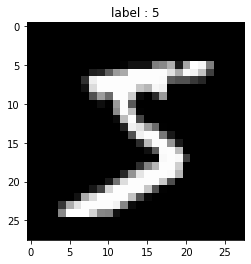

In [16]:
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap = 'gray')
plt.title('label : %d' %label)
plt.show()

3차원 텐서[1, 28, 28]를 2차원으로 줄이기 위해 image.squeeze()를 사용. squeeze() 함수는 크기가 1인 차원을 없애는 함수로 2차원인 [28, 28]로 만들어 줌.

## 미니 배치 구성하기

In [21]:
# torch.utils.data.DataLoader은 손쉽게 배치를 구성하며 학습 과정을 반복 시행할 때마다 미니 배치를 하나씩 불러오는 유용한 함수
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                          shuffle = True)
test_loadet = torch.utils.data.DataLoader(dataset = test_data,
                                         batch_size = batch_size,
                                         shuffle = True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


60,000개의 학습 데이터에 50의 배치 사이즈를 사용했기 때문에 = 12,000개의 미니 배치가 생성
미니배치의 첫 번째 요소 first_batch[0]는 [50, 1, 28, 28] 형태의 4차원 Tensor로서, 각 요소는 [Bath Size, Channel, Width, Height]를 나타냄.  
first_batch[1]은 50 크기의 벡터로서, 미니 배치의 정답이 저장되어 있음

## CNN 구조 설계

In [22]:
class CNN(nn.Module): # nn.Module 클래스를 상속받는 CNN 클래스를 정의
    def __init__(self): # __init__를 통해 모델에서 사용되는 가중치를 정의
        super(CNN, self).__init__() # supter() 함수를 통해 nn.Module 클래스의 속성을 상속받고 초기화
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1
        self.dropout1 = nn.Dropout2d(0.25) # 0.25확률인 Dropout
        self.dropout2 = nn.Dropout2d(0.5) # 0.5 확률인 Dropout
        self.fc1 = nn.Linear(9216, 128) # Fully-connected Layer 9216크기인 벡터를 128 크기의 백터로 변환하는 가중치를 설계
        self.fc2 = nn.Linear(128, 10) # Mnist의 클래스 개수인 10 크기의 벡터로 변환하는 가중치
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x) # ReLU 활성 함수를 적용. 활성 함수는 단순 연산이므로. __init__에서 정의한 학습 가중치가 없음
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # (2x2)크기의 Filter로 Max Pooling을 적용.
        x = self.dropout1(x)
        x = torch.flatten(x, 1) # 고차원의 Tensor을 1차원의 벡터로 변환
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim = 1) # 최종 출력값으로 log-softmax를 계산, Softmax함수가 아닌, log_softmax()를 사용 하면 연산속도를 높일 수 있음
        return output

## Optimizer 및 손실 함수 확인

In [23]:
model = CNN().to(device) # CNN 클래스를 이용해 model이라는 인스턴스를 생성. 코드 상단에 지정한 연산 장비 device를 인식
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # Adam 알고리즘의 optimizer를 지정
criterion = nn.CrossEntropyLoss() # Cross Entropy를 손실 함수로 지정 - 다중 클래스 분류 문제이기 때문에

## 설계한 CNN 모형 확인하기

In [24]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 모델 학습

In [27]:
model.train()
i = 0
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)     # 미니 배치의 데이터를 기존에 지정한 장비 device에 할당
        target = target.to(device) # 미니 배치의 정답를 기존에 지정한 장비 device에 할당
        optimizer.zero_grad() # 학습을 시작하기 전, 이전 반복 시행에서 저장된 optimizer의 Gradient를 초기화함
        output = model(data) # Feed Forward 연산으로 결과값을 계산
        loss = criterion(output, target) # 계산된 결과값과 실제 정답으로 손실 함수를 계산
        loss.backward() # 손실 함수를 통해 Gradient를 계산
        optimizer.step() # 위에서 계산된 Gradient를 통해 모델의 가중치를 업데이트 함
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

Train Step: 0	Loss: 2.309
Train Step: 1000	Loss: 0.200
Train Step: 2000	Loss: 0.217
Train Step: 3000	Loss: 0.058
Train Step: 4000	Loss: 0.292
Train Step: 5000	Loss: 0.088
Train Step: 6000	Loss: 0.053
Train Step: 7000	Loss: 0.050
Train Step: 8000	Loss: 0.209
Train Step: 9000	Loss: 0.011
Train Step: 10000	Loss: 0.017
Train Step: 11000	Loss: 0.008
Train Step: 12000	Loss: 0.003
Train Step: 13000	Loss: 0.010
Train Step: 14000	Loss: 0.135
Train Step: 15000	Loss: 0.028
Train Step: 16000	Loss: 0.201
Train Step: 17000	Loss: 0.012


## 모델 평가

In [32]:
model.eval() # 평가 모드를 싱행하기 위해 명시. eval() 호출하면, Dropout이 적용되지 않고 Batch-Normalization도 평가 모드로 전환
correct = 0
for data, target in test_loadet:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction += output.data.max(1)[1] # Log-Softmax 값이 가장 큰 인덱스를 예측값으로 저장
    correct += prediction.eq(target.data).sum() # 실제 정답 예측값이 같으면 True, 다르면 False인 논리값으로 구성된 벡터를 더함.
    # 즉, 미니 배치중 정답의 개수를 구하고 반복 시행마다 누적해서 더함
    
print('Test set: Accuracy: {:.2f}%'.format(100*correct/len(test_loadet.dataset)))

Test set: Accuracy: 0.00%
